Preprocessing and Embeddings:
https://colab.research.google.com/github/ImperialNLP/NLPLabs-2025/blob/main/lab01-preprocessing-and-word-embeddings/lab01_solutions.ipynb

Sentiment Analysis:
https://colab.research.google.com/github/ImperialNLP/NLPLabs-2025/blob/main/lab02-sentiment-classification/lab02_solutions.ipynb

Neural Language Models:
https://colab.research.google.com/github/ImperialNLP/NLPLabs-2025/blob/main/lab03-language-models/lab03_part_2_NeuralLMs_Solutions.ipynb

In [1]:
import importlib, utils
importlib.reload(utils)
from utils import *
import matplotlib.pyplot as plt
import numpy as np

/vol/bitbucket/et422/nlp_venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset = "Dont_Patronize_Me_Trainingset/dontpatronizeme_pcl.tsv"

In [3]:
parsed = load_dataset(dataset)

## 1. Basic Statistical Profiling
Token counts, vocabulary size, and class distribution — to determine model constraints like `max_length` and whether data augmentation is needed.

Total samples: 10468
Min: 0, Max: 820, Mean: 43.9, Median: 38, Std: 26.3
Percentiles — p50: 38, p75: 54, p90: 76, p95: 92, p99: 129


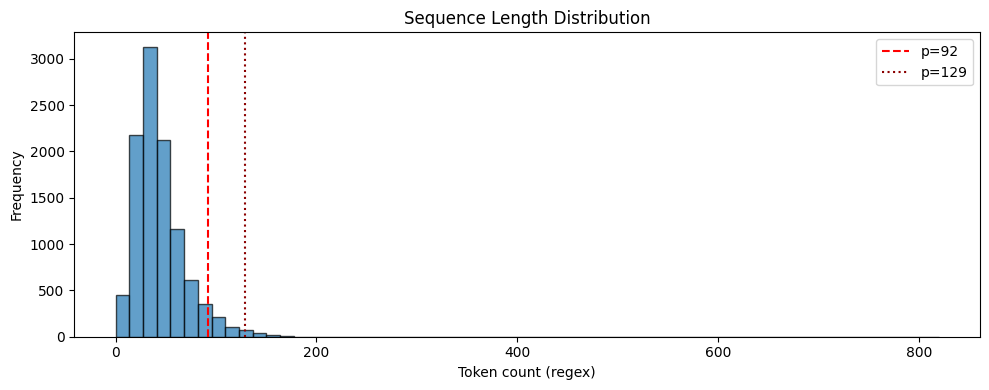

In [4]:
# Token length distribution (regex tokeniser — word-level)
dist = length_distribution(parsed, TOKENISERS["regex"])
print(f"Total samples: {len(parsed)}")
print(f"Min: {dist['min']}, Max: {dist['max']}, Mean: {dist['mean']:.1f}, Median: {dist['median']}, Std: {dist['std']:.1f}")
print(f"Percentiles — p50: {dist['p50']}, p75: {dist['p75']}, p90: {dist['p90']}, p95: {dist['p95']}, p99: {dist['p99']}")

fig, ax = plt.subplots(figsize=(10, 4))
ax.hist(dist["lengths"], bins=60, edgecolor="black", alpha=0.7)
for p, color, ls in [(dist["p95"], "red", "--"), (dist["p99"], "darkred", ":")]:
    ax.axvline(p, color=color, linestyle=ls, label=f"p={p}")
ax.set_xlabel("Token count (regex)")
ax.set_ylabel("Frequency")
ax.set_title("Sequence Length Distribution")
ax.legend()
plt.tight_layout()
plt.show()

In [5]:
# Vocabulary size comparison across tokenisers
for name in ["regex", "bpe"]:
    stats = corpus_stats(parsed, TOKENISERS[name])
    print(f"[{name:>10}]  vocab={stats['vocab_size']:,}  avg_len={stats['avg_len']:.1f}  "
          f"min={stats['min_len']}  max={stats['max_len']}")

[     regex]  vocab=30,035  avg_len=43.9  min=0  max=820
[       bpe]  vocab=28,360  avg_len=53.6  min=0  max=1003


In [6]:
# Class distribution
classes, binary = label_stats(parsed)

total = sum(binary.values())
for lbl, cnt in sorted(binary.items(), key=lambda t: t[0].value):
    print(f"  {lbl.name:>8}: {cnt:,}  ({cnt/total*100:.1f}%)")
print(f"\nImbalance ratio (NO_PCL / PCL): {binary[PCLBinaryLabel.NO_PCL] / binary[PCLBinaryLabel.PCL]:.1f}:1")

    NO_PCL: 9,475  (90.5%)
       PCL: 993  (9.5%)

Imbalance ratio (NO_PCL / PCL): 9.5:1


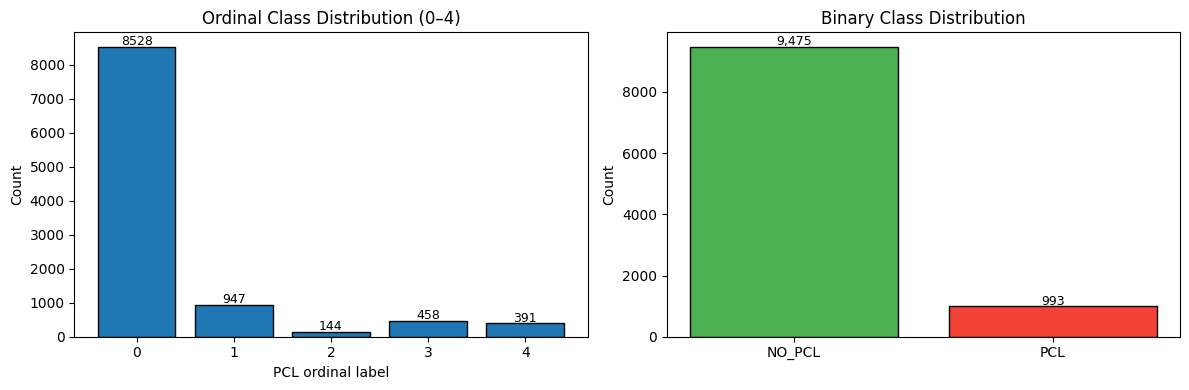

In [7]:
# Ordinal class distribution plot
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Ordinal (0-4)
x_ord = sorted(classes.keys())
y_ord = [classes[c] for c in x_ord]
axes[0].bar(x_ord, y_ord, edgecolor="black")
axes[0].set_xlabel("PCL ordinal label")
axes[0].set_ylabel("Count")
axes[0].set_title("Ordinal Class Distribution (0–4)")
axes[0].set_xticks(x_ord)
for i, v in enumerate(y_ord):
    axes[0].text(x_ord[i], v + 50, str(v), ha='center', fontsize=9)

# Binary
labels = ["NO_PCL", "PCL"]
counts = [binary[PCLBinaryLabel.NO_PCL], binary[PCLBinaryLabel.PCL]]
colours = ["#4CAF50", "#F44336"]
axes[1].bar(labels, counts, color=colours, edgecolor="black")
axes[1].set_title("Binary Class Distribution")
axes[1].set_ylabel("Count")
for i, v in enumerate(counts):
    axes[1].text(i, v + 50, f"{v:,}", ha='center', fontsize=9)

plt.tight_layout()
plt.show()

### Takeaways — Basic Stats
- **Class imbalance**: The dataset is heavily skewed — 90.5% NO_PCL vs 9.5% PCL (9.5:1 ratio). A naive majority-class baseline would achieve 90.5% accuracy. **Action**: use stratified splits; consider class-weighted loss or oversampling to prevent the model collapsing to always predicting the majority class.
- **Sequence length**: Mean length is ~44 regex tokens (median 38), with a strong right skew (max 820). **p95 = 92 tokens** covers 95% of samples; p99 = 129. **Action**: set `max_length` ≈ 128 BPE tokens (BPE avg is ~54, so 128 covers well past p95 with headroom).
- **Vocabulary**: Regex vocab is 30,035 unique words; BPE vocab is 28,360 subword tokens. The large word-level vocabulary favours subword tokenisation or pre-trained embeddings over training an embedding matrix from scratch on this small dataset (only ~10k samples).
- **Zero-length samples**: The minimum token count is 0, indicating empty or whitespace-only samples exist — these should be filtered out during preprocessing.

## 2. Lexical Analysis (Word Level)
N-gram analysis, stop-word density, and frequency comparison between PCL and non-PCL classes.

In [8]:
# Top bigrams
bigrams = top_ngrams(parsed, TOKENISERS["regex"], n=2, k=20)
for gram, cnt in bigrams:
    print(f"  {' '.join(gram):30s} {cnt:,}")

  of the                         2,707
  in the                         2,423
  to the                         1,313
  in need                        1,025
  poor families                  921
  for the                        872
  on the                         811
  to be                          740
  and the                        730
  n t                            687
  at the                         652
  need of                        605
  in a                           576
  by the                         560
  that the                       549
  of a                           540
  from the                       535
  with the                       501
  it is                          497
  is a                           448


In [9]:
# Top trigrams
trigrams = top_ngrams(parsed, TOKENISERS["regex"], n=3, k=20)
for gram, cnt in trigrams:
    print(f"  {' '.join(gram):40s} {cnt:,}")

  in need of                               594
  from poor families                       230
  do n t                                   202
  one of the                               190
  those in need                            162
  as well as                               153
  the united states                        145
  the number of                            135
  the most vulnerable                      122
  in the country                           114
  are in need                              111
  some of the                              105
  according to the                         101
  the u s                                  93
  need of a                                88
  ca n t                                   87
  poor families and                        84
  people in need                           84
  poor families in                         84
  men and women                            81


In [10]:
# Stop-word density
density = stop_word_density(parsed)
print(f"Stop-word density: {density:.2%}")
print(f"  → {density:.0%} of all tokens are stop words")

Stop-word density: 41.34%
  → 41% of all tokens are stop words


In [11]:
# Top words after stop-word removal (whole corpus)
print("Top 20 content words (corpus-wide, lemmatised):")
for word, cnt in top_words(parsed, k=20):
    print(f"  {word:20s} {cnt:,}")

Top 20 content words (corpus-wide, lemmatised):


  say                  2,587
  people               1,863
  immigrant            1,837
  woman                1,822
  need                 1,693
  family               1,689
  refugee              1,456
  child                1,245
  year                 1,243
  poor                 1,232
  vulnerable           1,205
  country              1,133
  disabled             1,065
  homeless             1,034
  government           905
  new                  812
  work                 757
  help                 739
  migrant              670
  come                 635


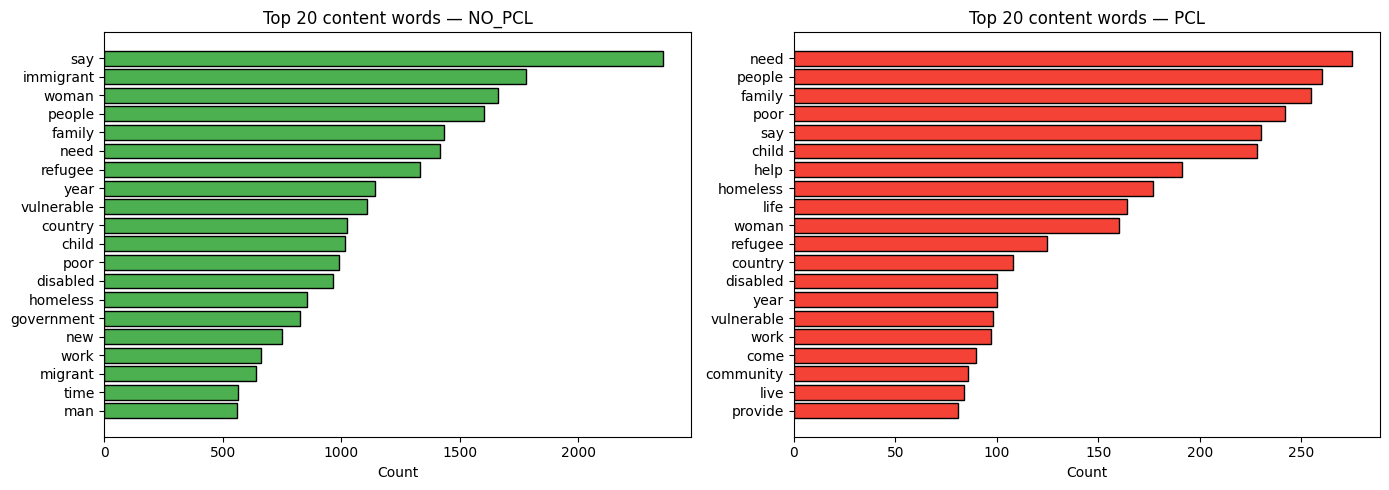

Words in PCL top-20 but NOT in NO_PCL top-20: {'live', 'community', 'come', 'help', 'life', 'provide'}
Words in NO_PCL top-20 but NOT in PCL top-20: {'migrant', 'government', 'man', 'immigrant', 'time', 'new'}


In [12]:
# Class-comparative word analysis: PCL vs non-PCL
cmp = class_top_words(parsed, k=20)

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=False)

for ax, (label, data) in zip(axes, [("NO_PCL", cmp["no_pcl"]), ("PCL", cmp["pcl"])]):
    words = [w for w, _ in reversed(data)]
    counts = [c for _, c in reversed(data)]
    colour = "#4CAF50" if label == "NO_PCL" else "#F44336"
    ax.barh(words, counts, color=colour, edgecolor="black")
    ax.set_title(f"Top 20 content words — {label}")
    ax.set_xlabel("Count")

plt.tight_layout()
plt.show()

# Words unique to PCL top-20 vs NO_PCL top-20
pcl_set = {w for w, _ in cmp["pcl"]}
no_pcl_set = {w for w, _ in cmp["no_pcl"]}
print(f"Words in PCL top-20 but NOT in NO_PCL top-20: {pcl_set - no_pcl_set}")
print(f"Words in NO_PCL top-20 but NOT in PCL top-20: {no_pcl_set - pcl_set}")

### Takeaways — Lexical Analysis
- **Stop-word density**: 41% of all tokens are stop words — substantial but not extreme. Transformer models handle this via attention; for classical models (TF-IDF, etc.), removing stop words will sharpen signal.
- **N-grams**: The top bigrams ("of the", "in the", "to the") and trigrams ("in need of", "from poor families", "do n t") are overwhelmingly generic or stop-word-dominated. The phrase **"in need of"** (594 occurrences) is notable — it may correlate with patronising framing (e.g. "those in need of help"). No single n-gram cleanly separates PCL from non-PCL, confirming that PCL detection requires understanding **tone**, not just keyword matching.
- **Top content words (corpus-wide)**: After fixing punctuation leakage, the top lemmatised words — *say, immigrant, woman, people, family, need, refugee* — reflect the dataset's topical focus on vulnerable communities. These are **topic words**, not PCL indicators.
- **Class-comparative words**: 14 of the top-20 words are shared between PCL and non-PCL. PCL-exclusive top words (**help, life, come, provide, community, live**) suggest a more *emotive/prescriptive* register, while non-PCL-exclusive words (**immigrant, government, migrant, new, man, time**) are more *factual/reportorial*. This tonal difference is subtle — bag-of-words methods will struggle; contextual embeddings (BERT-class) are preferable.

## 3. Semantic & Syntactic Exploration
POS tag distribution and Named Entity Recognition to understand the linguistic structure of the data.

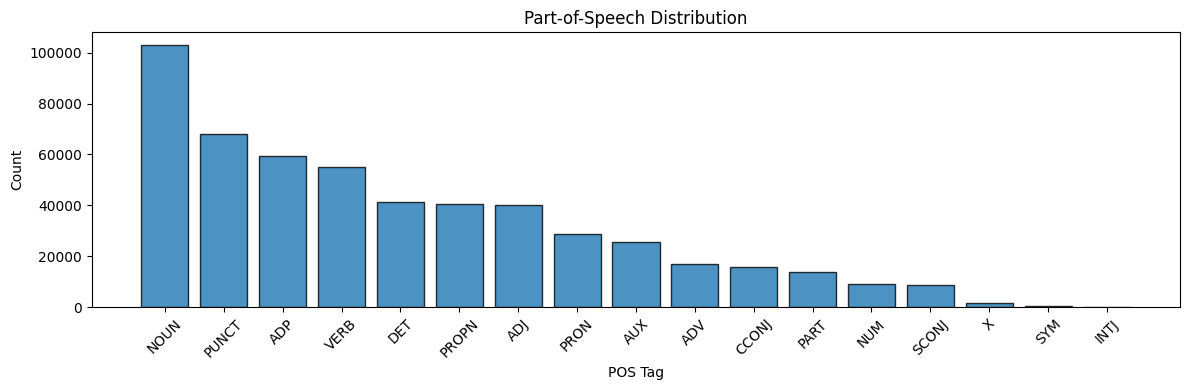

Noun count: 143,347, Verb count: 80,520, Noun:Verb ratio: 1.78


In [13]:
# POS tag distribution
pos = pos_distribution(parsed)
tags = [t for t, _ in pos.most_common()]
counts = [c for _, c in pos.most_common()]

fig, ax = plt.subplots(figsize=(12, 4))
ax.bar(tags, counts, edgecolor="black", alpha=0.8)
ax.set_xlabel("POS Tag")
ax.set_ylabel("Count")
ax.set_title("Part-of-Speech Distribution")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Noun-to-verb ratio
nouns = pos.get("NOUN", 0) + pos.get("PROPN", 0)
verbs = pos.get("VERB", 0) + pos.get("AUX", 0)
print(f"Noun count: {nouns:,}, Verb count: {verbs:,}, Noun:Verb ratio: {nouns/verbs:.2f}")

NER Entity Type Distribution (top 15):
  ORG         6,774   e.g. "White House"
  GPE         6,669   e.g. "Libya"
  PERSON      5,425   e.g. "Sean Spicer"
  DATE        5,135   e.g. "today"
  CARDINAL    4,633   e.g. "two"
  NORP        3,087   e.g. "Ghanaian"
  LOC           812   e.g. "Europe"
  ORDINAL       644   e.g. "first"
  MONEY         393   e.g. "more than $50 million"
  WORK_OF_ART    388   e.g. "Ghostbusters"
  PERCENT       371   e.g. "97%"
  TIME          319   e.g. "those few seconds"
  FAC           287   e.g. "St. Luke 's"
  EVENT         187   e.g. "World Refugee Day"
  QUANTITY      166   e.g. "more than 1 million"


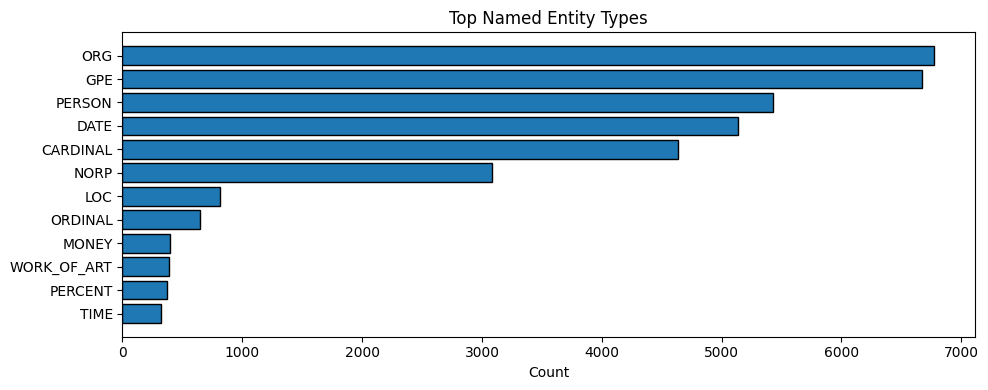

In [14]:
# Named Entity Recognition distribution
ner_counts, ner_examples = ner_distribution(parsed)

print("NER Entity Type Distribution (top 15):")
for ent_type, cnt in ner_counts.most_common(15):
    print(f"  {ent_type:10s} {cnt:>6,}   e.g. \"{ner_examples[ent_type]}\"")

fig, ax = plt.subplots(figsize=(10, 4))
top_ner = ner_counts.most_common(12)
ax.barh([t for t, _ in reversed(top_ner)], [c for _, c in reversed(top_ner)], edgecolor="black")
ax.set_xlabel("Count")
ax.set_title("Top Named Entity Types")
plt.tight_layout()
plt.show()

### Takeaways — Semantic & Syntactic
- **POS distribution**: NOUN dominates (~103k), followed by PUNCT (~68k), ADP (~60k), VERB (~55k). The **noun:verb ratio is 1.78**, confirming noun-heavy, descriptive/reportorial text typical of news articles about communities. The high PROPN count (~40k) reflects frequent named-entity references.
- **NER**: ORG (6,774), GPE (6,669), and PERSON (5,425) dominate — the dataset is rich in references to specific organisations, countries, and people (e.g. "White House", "Libya", "Sean Spicer"). NORP (3,087) captures demonyms/group names (e.g. "Ghanaian"), directly relevant to the communities discussed. **Risk**: the model could overfit to specific entity names rather than learning patronising tone. **Action**: consider entity masking (replacing names with `[PERSON]`, `[GPE]` etc.) as an augmentation strategy to force the model to focus on language patterns rather than memorised names.

## 4. Noise and Artifacts
Detect duplicates, label disagreements, outliers, weird characters, and HTML artefacts.

In [15]:
# Non-printable / weird characters
weird = find_weird_chars(parsed)
if weird:
    print("Non-printable characters found:")
    for ch, cnt in weird.most_common():
        print(f"  {repr(ch):10s}  count={cnt}")
else:
    print("No non-printable characters found.")

No non-printable characters found.


In [16]:
# HTML tags, entities, URLs, escaped newlines
artefacts = html_and_entity_scan(parsed)
for name, hits in artefacts.items():
    print(f"{name}: {len(hits)} documents affected")
    for par_id, matches in hits[:3]:  # show first 3 examples
        print(f"    par_id={par_id}: {matches}")

html_tags: 401 documents affected
    par_id=16: ['<h>', '<h>', '<h>']
    par_id=38: ['<h>']
    par_id=55: ['<h>']
html_entities: 78 documents affected
    par_id=56: ['&gt;', '&gt;']
    par_id=99: ['&amp;']
    par_id=249: ['&amp;']
urls: 0 documents affected
escaped_newlines: 0 documents affected


In [17]:
# Duplicate detection
dupes = find_duplicates(parsed)
print(f"Unique texts: {len(set(x.text for x in parsed)):,} / {len(parsed):,} total")
print(f"Duplicate texts (appearing >1 time): {len(dupes)}")
if dupes:
    print(f"\nTop 5 most repeated:")
    for text, cnt in dupes[:5]:
        print(f"  [{cnt}x] {text[:100]}...")

Unique texts: 10,468 / 10,468 total
Duplicate texts (appearing >1 time): 0


In [18]:
# Label disagreements — same text with different labels (annotation noise)
disagreements = find_label_disagreements(parsed)
print(f"Texts with conflicting labels: {len(disagreements)}")
if disagreements:
    for text, labels in list(disagreements.items())[:3]:
        print(f"  Labels {labels}: \"{text[:80]}...\"")

Texts with conflicting labels: 0


In [19]:
# Outlier sequences (extremely short or long)
outliers = find_outliers(parsed, TOKENISERS["regex"])
print(f"Lower threshold (p1): {outliers['lo_thresh']:.0f} tokens")
print(f"Upper threshold (p99): {outliers['hi_thresh']:.0f} tokens")
print(f"Short outliers (<p1): {len(outliers['short'])}")
print(f"Long outliers  (>p99): {len(outliers['long'])}")

if outliers["short"]:
    print("\nShortest examples:")
    for item, length in sorted(outliers["short"], key=lambda t: t[1])[:3]:
        print(f"  [{length} tokens] \"{item.text[:80]}\"")

if outliers["long"]:
    print("\nLongest examples:")
    for item, length in sorted(outliers["long"], key=lambda t: -t[1])[:3]:
        print(f"  [{length} tokens] \"{item.text[:80]}...\"")

Lower threshold (p1): 8 tokens
Upper threshold (p99): 129 tokens
Short outliers (<p1): 98
Long outliers  (>p99): 101

Shortest examples:
  [0 tokens] ""
  [1 tokens] "refugees"
  [2 tokens] "Feeling hopeless"

Longest examples:
  [820 tokens] ""Dr Mayengbam Lalit Singh Recently honourable PM of India launched scheme called..."
  [467 tokens] ""Most are from desperately poor Horn of Africa countries and like tens of thousa..."
  [376 tokens] ""Mahinda Wijesinghe , the Inspector General of the Ridiyagama Government Detenti..."


### Takeaways — Noise and Artifacts
- **No duplicates**: All 10,468 texts are unique — no deduplication needed and no risk of train/test leakage from repeated samples.
- **No label disagreements**: Every text has a consistent label, so annotation noise is not a concern for this dataset.
- **HTML artefacts**: 401 documents contain `<h>` tags and 78 contain HTML entities (`&gt;`, `&amp;`). **Action**: strip HTML tags and decode entities during preprocessing (e.g. `html.unescape()` + regex removal of `<h>` tags).
- **No non-printable characters**: The text is clean at the character level — no hidden Unicode or control characters.
- **Outliers**: 98 samples have fewer than 8 tokens (p1 threshold), including empty strings and single-word entries like "refugees". 101 samples exceed 129 tokens (p99), with the longest at 820 tokens. **Action**: filter out empty/near-empty samples; the long tail confirms the `max_length ≈ 128` recommendation — only ~1% of data is truncated.

## 5. Keyword–Label Correlation
Check whether the `keyword` metadata field alone could predict PCL. If so, the model might shortcut by learning keyword → label mappings rather than actual language patterns.

Keyword                     Total    PCL  PCL Rate
--------------------------------------------------
  migrant                   1,089     36     3.3%
  in-need                   1,082    176    16.3%
  vulnerable                1,080     80     7.4%
  homeless                  1,077    178    16.5%
  women                     1,070     52     4.9%
  refugee                   1,068     86     8.1%
  immigrant                 1,061     30     2.8%
  disabled                  1,028     81     7.9%
  hopeless                  1,004    124    12.4%
  poor-families               909    150    16.5%


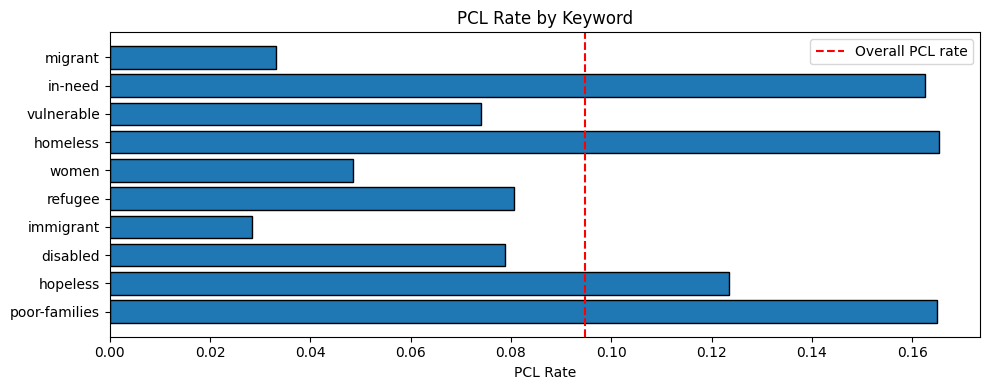

In [20]:
# Keyword → PCL rate
kw_corr = keyword_label_correlation(parsed)

print(f"{'Keyword':25s} {'Total':>7s} {'PCL':>6s} {'PCL Rate':>9s}")
print("-" * 50)
for kw, stats in kw_corr.items():
    print(f"  {kw:23s} {stats['total']:>7,} {stats['pcl']:>6,} {stats['pcl_rate']:>8.1%}")

# Visualise
kws = list(kw_corr.keys())
rates = [kw_corr[k]["pcl_rate"] for k in kws]

fig, ax = plt.subplots(figsize=(10, 4))
ax.barh(list(reversed(kws)), list(reversed(rates)), edgecolor="black")
ax.axvline(sum(x.is_pcl for x in parsed) / len(parsed), color="red", linestyle="--", label="Overall PCL rate")
ax.set_xlabel("PCL Rate")
ax.set_title("PCL Rate by Keyword")
ax.legend()
plt.tight_layout()
plt.show()

### Takeaways — Keyword Correlation
- **PCL rate varies dramatically by keyword**: "homeless" (16.5%), "poor-families" (16.5%), and "in-need" (16.3%) have PCL rates ~5× higher than "immigrant" (2.8%) and "migrant" (3.3%). The overall PCL rate is 9.5%.
- **Implication**: if the keyword field were used as an input feature, the model could achieve non-trivial performance by simply learning the keyword → PCL-rate mapping (a shortcut). This would not generalise to new topics.
- **Action**: ensure the keyword is **not** included as a model input feature. Use **keyword-stratified** cross-validation so each fold reflects the same keyword distribution, preventing the model from being evaluated on an artificially easy/hard keyword split.

---
## Summary of Actionable Insights

| Finding | Action |
|---|---|
| 90.5/9.5 class imbalance (9.5:1) | Use stratified splits, class-weighted loss, or oversampling |
| p95 = 92 regex tokens; BPE avg = 54 | Set `max_length ≈ 128` BPE tokens — covers >95% of samples |
| Empty samples exist (min length = 0) | Filter out empty/near-empty samples during preprocessing |
| 41% stop-word density | Transformers handle via attention; for TF-IDF, remove stop words |
| PCL vs non-PCL top-word overlap is 14/20 | BoW features will be weak; contextual embeddings (BERT-class) are needed |
| PCL-exclusive words (*help, life, provide, community*) suggest emotive register | The task is about *tone*, not *topic* — models must capture pragmatics |
| 401 docs with `<h>` tags, 78 with HTML entities | Strip tags + `html.unescape()` in preprocessing |
| No duplicates, no label disagreements | No deduplication needed; clean annotation |
| Keyword PCL rate ranges from 2.8% to 16.5% | Do NOT use keyword as input; use keyword-stratified CV |
| NER dominated by ORG, GPE, PERSON | Consider entity masking to prevent overfitting to specific names |